In [7]:
from collections import Counter
import dill
import seaborn as sns
import pandas as pd

import os
import sys
sys.path.append('..')

from config import DATASET_DILL_OUTPUT_PATH


In [8]:
with open(os.path.join('..', DATASET_DILL_OUTPUT_PATH), 'rb') as f:
  results = dill.load(f)

In [9]:
ERROR_MAPPING = {
  'File not found': 'Missing File',
  'requires different compiler version' : 'Wrong Compiler Version',
  'SPDX license identifier' : 'Missing license',
  'Only state variables or file-level variables can have a docstring': 'Invalid Docstring',
  'Stack too deep': 'Stack too deep',
  'Error: Expected': 'Syntax',
  'Documentation tag @custom:attribution not valid for contracts.': 'Invalid Documentation Tag',
  'Internal compiler error': 'Internal Compiler Error',
  'Interfaces cannot inherit': 'Interfaces Cannot Inherit',
  'not found or not visible after argument-dependent lookup': 'Method Not Found',
  'Location has to be calldata for external functions': 'Location Must Be Calldata',
}

In [10]:
errors_by_project = {}
errors = []
for result in results:
  fs = [str(f[1]) for f in result.failures]
  errs = []
  for f in fs:
    for match, cat in ERROR_MAPPING.items():
      if match in f:
        errs.append(cat)
  
  errors += errs
  errors_by_project[result.project_name] = Counter(errs)
errors = Counter(errors)

/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/Caskroom/miniconda/base/envs/p310/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype i

Text(0, 0.5, 'Num Files')

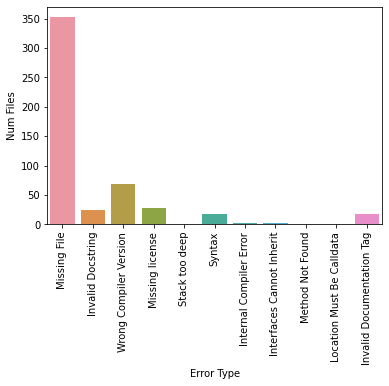

In [11]:
ax = sns.barplot(x=list(errors.keys()), y=list(errors.values()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
ax.set_xlabel('Error Type')
ax.set_ylabel('Num Files')


In [15]:
from pprint import pprint
for result in results:
  pprint([f[0] for f in result.failures if 'mock' in f[0]])

[]
['project-repos/AAVE/aave-v3-core/contracts/mocks/tests/MockReserveInterestRateStrategy.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/helpers/MockReserveConfiguration.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/tests/FlashloanAttacker.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/upgradeability/MockVariableDebtToken.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/helpers/MockL2Pool.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/helpers/MockPool.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/upgradeability/MockAToken.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/upgradeability/MockStableDebtToken.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/flashloan/MockFlashLoanReceiver.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/flashloan/MockSimpleFlashLoanReceiver.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/tokens/WETH9Mocked.sol',
 'project-repos/AAVE/aave-v3-core/contracts/mocks/tokens/MockAT

In [16]:
{n: e['Missing File'] for n, e in errors_by_project.items()}

{'DAI': 5,
 'AAVE': 8,
 'USD Tether': 0,
 'Polygon': 64,
 'USDC': 31,
 'Shiba Inu': 64,
 'Toncoin': 0,
 'Uniswap': 0,
 'Lido DAO': 73,
 'Immutable': 37,
 'Mantle': 59,
 'Cronos': 11}